Keras: Photo prediction

#Connect to Python 3.10 - Pytorch and Tensorflow kernel

In [1]:
import os
# Force TensorFlow to use CPU only (avoids GPU memory errors)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

2026-02-08 16:03:20.424343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770566600.443951   15550 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770566600.450119   15550 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770566600.465236   15550 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770566600.465251   15550 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770566600.465253   15550 computation_placer.cc:177] computation placer alr

In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = True

# Define File_Helper class locally to avoid importing it from a separate file, which can cause issues in Jupyter notebooks.
class File_Helper:

	"""
	These routines let us conveniently save and load input data, such
	as text and image files, as well as save and load Keras model files
	and weight files.  When we save a file, the corresponding directory 
	is created if necessary. 
	
	When we make the object, we can optionally set the one argument really_save_files
	to True or False, depending on whether or not we want save_xx() calls to really
	write files. It's time-saving to set this to False when debugging because writing
	files can take a while. The default value is True.
	
	Here's a typical way to import this package from a file in a folder two levels down
	(adapted from https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
	
	# find the absolute path to the parent folder and add that to Python's search list
	import os, sys, inspect
	current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
	sys.path.insert(0, os.path.dirname(current_dir)) # path to grandparent dir
	# Now that we can find the folder, import the package and instantiate a File_Helper object
	from Python_Utilities import File_Helper
	file_helper = File_Helper(True)  
	"""
	
	def __init__(self, really_save_files=True):
		self.really_save_files = really_save_files
		self.saved_output_dir = 'saved_output'
		self.input_data_dir = 'input_data'
		self.saved_models_dir = 'saved_models'
		self.saved_weights_dir = 'saved_weights'

	def get_input_file_path(self, filename):
		"""Get the local path relative to the calling file's location to the input file"""
		return self.input_data_dir + '/' + filename
	
	def check_for_directory(self, directory, create_if_needed=True):
		"""See if the directory exists. Optionally, create it."""
		path_exists = os.path.exists(directory)
		if path_exists:
			if not os.path.isdir(directory):
				raise Exception('Found '+directory+' but it is a file, not a directory')
				return False
			return True
		if create_if_needed:
			os.makedirs(directory)
		return path_exists

	def save_figure(self, filename):
		"""Save the figure. Call this just before plt.show()."""
		if self.really_save_files and (filename != None):
			self.check_for_directory(self.saved_output_dir)
			plt.savefig(self.saved_output_dir+'/'+filename+'.png', dpi=300, bbox_inches='tight')

	def load_model_weights(self, model, weights_filename):
		"""If the weights file exists, load from it and return True, else return False."""
		fullpath = self.saved_weights_dir+'/'+weights_filename+'.h5'
		if os.path.exists(fullpath):
			if os.path.isfile(fullpath):
				model.load_weights(fullpath)
				return True
		return False

	def save_model_weights(self, model, weights_filename):
		"""Save the weights file in the saved weights directory."""
		if self.really_save_files and (weights_filename != None):
			self.check_for_directory(self.saved_weights_dir)
			fullpath = self.saved_weights_dir+'/'+weights_filename+'.h5'
			model.save_weights(fullpath)

	def load_model(self, model_filename):
		"""If the model file exists, load from it and return the model, else return None."""
		fullpath = self.saved_models_dir+'/'+model_filename+'.h5'
		if os.path.exists(fullpath):
			if os.path.isfile(fullpath):
				model = load_model(fullpath)
				return model
		return None

	def save_model(self, model, model_filename):
		"""Save the model file in the saved models directory."""
		if self.really_save_files and (model_filename != None):
			self.check_for_directory(self.saved_models_dir)
			fullpath = self.saved_models_dir+'/'+model_filename+'.h5'
			model.save(fullpath)

	def get_saved_output_dir(self):
		"""Get the name of the directory where we save matplotlib output PNG files."""
		return self.saved_output_dir
	
	def get_input_data_dir(self):
		"""Get the name of the directory where we look for input files."""
		return self.input_data_dir
	
	def get_saved_weights_dir(self):
		"""Get the name of the directory where we read and write Keras weight files."""
		return self.saved_weights_dir
	
	def get_saved_models_dir(self):
		"""Get the name of the directory where we read and write Keras model files."""
		return self.saved_models_dir

file_helper = File_Helper(save_files)

In [4]:
# First we'll build our deep network and train it on the MNIST data.
# Then we can turn it loose on the Seattle photographs. We'll train
# for 20 epochs.

random_seed = 42

# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# convert to floating-point
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# save the original y_train and y_test 
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape samples to 2D grid, one line per image
X_train = X_train.reshape([X_train.shape[0], number_of_pixels])
X_test = X_test.reshape([X_test.shape[0], number_of_pixels])

def make_model():
    model = Sequential()
    model.add(Dense(number_of_pixels, activation='relu',
                    input_shape=[number_of_pixels]))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    return model

# make the model
model = make_model()

np.random.seed(random_seed)

# call fit() to train the model, and save the history
one_hidden_layer_history = model.fit(X_train, y_train,
    validation_split=0.25, epochs=10, batch_size=64, verbose=2)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-02-08 16:03:34.681901: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-02-08 16:03:34.681934: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2026-02-08 16:03:34.681940: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2026-02-08 16:03:34.681943: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rer

Epoch 1/10
704/704 - 4s - 5ms/step - accuracy: 0.9270 - loss: 0.2456 - val_accuracy: 0.9580 - val_loss: 0.1431
Epoch 2/10
704/704 - 3s - 4ms/step - accuracy: 0.9720 - loss: 0.0956 - val_accuracy: 0.9689 - val_loss: 0.1030
Epoch 3/10
704/704 - 3s - 4ms/step - accuracy: 0.9821 - loss: 0.0607 - val_accuracy: 0.9707 - val_loss: 0.0947
Epoch 4/10
704/704 - 3s - 4ms/step - accuracy: 0.9880 - loss: 0.0407 - val_accuracy: 0.9738 - val_loss: 0.0903
Epoch 5/10
704/704 - 3s - 4ms/step - accuracy: 0.9923 - loss: 0.0260 - val_accuracy: 0.9743 - val_loss: 0.0956
Epoch 6/10
704/704 - 3s - 4ms/step - accuracy: 0.9940 - loss: 0.0203 - val_accuracy: 0.9753 - val_loss: 0.0899
Epoch 7/10
704/704 - 3s - 4ms/step - accuracy: 0.9944 - loss: 0.0185 - val_accuracy: 0.9736 - val_loss: 0.1003
Epoch 8/10
704/704 - 3s - 4ms/step - accuracy: 0.9968 - loss: 0.0115 - val_accuracy: 0.9763 - val_loss: 0.0904
Epoch 9/10
704/704 - 3s - 4ms/step - accuracy: 0.9967 - loss: 0.0105 - val_accuracy: 0.9754 - val_loss: 0.0948
E

In [5]:
#
# My Seattle photos. Because I didn't want to depend on having other
# files around to read in (though in retrospect, I think that would
# be okay), I saved the data explicitly as integer arrays. What the
# heck, I've left them in here in that form. It does reduce outside
# dependencies, but it seems a silly choice to me now. Anyway, there's
# nothing interesting here, just intensities of the pixels in grayscale
# images. Intensities are in the range [0,255] and images are saved
# as a list of 748 elements (so we don't have to reshape them).
#

Coffeeshop_4 = np.array((
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 34, 166, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 2, 168, 172, 5, 176, 255, 255, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 68, 255, 255, 54, 162, 255, 255, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 149, 255, 255, 65, 120, 255, 255, 74, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 2, 243, 255, 255, 12, 89, 255, 255, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 157, 255, 255, 238, 0, 88, 255, 255, 113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 100, 255, 255, 255, 85, 0, 83, 255, 255, 108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 71, 252, 255, 253, 142, 0, 0, 58, 255, 255, 133, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 3, 82, 255, 255, 255, 234, 3, 0, 0, 37, 255, 255, 109, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 44, 255, 255, 255, 255, 250, 185, 131, 85, 155, 255, 255, 193, 40, 49, 8, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 11, 206, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 182, 3, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 69, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 83, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 46, 105, 99, 113, 153, 151, 185, 249, 255, 255, 248, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 191, 255, 255, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 161, 255, 255, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 136, 255, 255, 116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 255, 255, 120, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 255, 255, 166, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 41, 255, 255, 195, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 255, 255, 205, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 221, 255, 146, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 161, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
))
Coffeeshop_5 = np.array((
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 15, 34, 29, 36, 29, 30, 27, 82, 159, 82, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 117, 213, 224, 238, 252, 249, 255, 250, 251, 250, 255, 255, 255, 37, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 68, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 122, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 73, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 82, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 48, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 198, 4, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 1, 0, 64, 255, 255, 255, 202, 141, 107, 90, 103, 115, 133, 138, 63, 3, 0, 1, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 1, 0, 100, 255, 255, 255, 100, 2, 26, 71, 98, 76, 5, 0, 0, 1, 2, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 179, 255, 255, 255, 232, 222, 255, 255, 255, 255, 228, 44, 0, 1, 1, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 2, 224, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 245, 22, 0, 2, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 13, 246, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 196, 3, 1, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 60, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 40, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 1, 170, 255, 255, 255, 255, 255, 255, 255, 255, 178, 137, 250, 255, 255, 124, 2, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 1, 196, 255, 255, 255, 255, 204, 131, 204, 129, 7, 0, 159, 255, 255, 193, 9, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 65, 255, 255, 255, 196, 16, 0, 5, 0, 0, 0, 101, 255, 255, 170, 9, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 119, 253, 182, 0, 0, 0, 0, 0, 1, 0, 111, 255, 255, 178, 1, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 1, 0, 0, 60, 34, 0, 0, 0, 1, 1, 0, 15, 222, 255, 255, 149, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 2, 163, 235, 164, 0, 0, 0, 0, 40, 217, 255, 255, 255, 46, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 1, 206, 255, 255, 166, 17, 70, 154, 247, 255, 255, 255, 197, 1, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 150, 255, 255, 255, 240, 255, 255, 255, 255, 255, 229, 31, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 72, 255, 255, 255, 255, 255, 255, 255, 255, 220, 17, 0, 1, 1, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 120, 255, 255, 255, 255, 255, 255, 226, 29, 0, 0, 1, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 1, 181, 255, 255, 255, 228, 143, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 90, 106, 76, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
))
Coffeeshop_6 = np.array((
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 2, 2, 0, 0, 4, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 2, 6, 57, 31, 9, 0, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 41, 247, 224, 118, 12, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 2, 98, 255, 255, 255, 130, 9, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 5, 154, 255, 255, 255, 253, 24, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 14, 238, 255, 255, 255, 226, 21, 2, 2, 3, 0, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 13, 160, 255, 255, 255, 229, 24, 0, 1, 2, 16, 10, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 4, 58, 255, 255, 255, 237, 35, 0, 0, 31, 140, 150, 65, 18, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 3, 65, 255, 255, 255, 226, 28, 0, 19, 200, 255, 255, 255, 156, 21, 0, 1, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 4, 74, 255, 255, 255, 247, 48, 5, 95, 255, 255, 255, 255, 255, 171, 20, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 3, 82, 255, 255, 255, 253, 70, 13, 139, 255, 255, 255, 255, 255, 255, 164, 8, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 50, 255, 255, 255, 255, 100, 24, 168, 255, 255, 255, 247, 255, 255, 255, 142, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 16, 175, 255, 255, 255, 93, 49, 255, 255, 255, 255, 96, 81, 254, 255, 255, 84, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 9, 109, 255, 255, 255, 147, 55, 244, 255, 255, 254, 39, 18, 189, 255, 255, 188, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 2, 71, 255, 255, 255, 180, 45, 210, 255, 255, 248, 37, 7, 122, 255, 255, 200, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 20, 199, 255, 255, 178, 54, 190, 255, 255, 199, 17, 26, 148, 255, 255, 201, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 18, 167, 255, 255, 229, 65, 163, 255, 255, 192, 48, 116, 244, 255, 255, 211, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 7, 103, 255, 255, 255, 167, 203, 255, 255, 253, 221, 255, 255, 255, 255, 123, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 2, 38, 223, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 181, 13, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 4, 10, 113, 255, 255, 255, 255, 255, 255, 255, 255, 255, 252, 150, 20, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 3, 0, 17, 157, 249, 255, 255, 255, 255, 243, 193, 142, 61, 15, 0, 2, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 2, 4, 0, 17, 53, 69, 81, 72, 70, 46, 23, 10, 0, 0, 4, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 4, 5, 1, 2, 6, 6, 6, 3, 1, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 16, 15, 15, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
))
Coffeeshop_8 = np.array((
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 2, 4, 6, 12, 9, 4, 5, 5, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 3, 6, 3, 17, 201, 197, 30, 5, 8, 6, 6, 8, 5, 1, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 6, 4, 25, 204, 255, 255, 230, 122, 65, 9, 4, 7, 8, 6, 1, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 4, 35, 226, 255, 255, 255, 255, 255, 255, 214, 87, 6, 5, 9, 3, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 5, 152, 255, 255, 255, 255, 255, 255, 255, 255, 255, 142, 8, 8, 2, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 9, 206, 255, 255, 255, 193, 239, 250, 225, 255, 255, 255, 115, 7, 1, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 6, 213, 255, 255, 183, 15, 36, 46, 15, 180, 255, 255, 191, 9, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 5, 180, 255, 255, 82, 0, 0, 4, 24, 192, 255, 255, 236, 12, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 5, 154, 255, 255, 204, 119, 124, 148, 237, 255, 255, 255, 97, 8, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 5, 44, 252, 255, 255, 255, 255, 255, 255, 255, 255, 95, 13, 6, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 6, 10, 137, 255, 255, 255, 255, 255, 255, 255, 255, 97, 5, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 7, 12, 114, 255, 255, 255, 255, 255, 255, 255, 255, 255, 202, 117, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 5, 12, 218, 255, 255, 255, 211, 93, 76, 152, 255, 255, 255, 255, 123, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 3, 13, 223, 255, 255, 226, 18, 0, 2, 5, 84, 255, 255, 255, 245, 8, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 3, 16, 193, 255, 255, 130, 6, 8, 6, 7, 4, 86, 254, 255, 255, 90, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 3, 11, 196, 255, 255, 48, 5, 8, 7, 6, 1, 18, 253, 255, 255, 102, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 2, 6, 183, 255, 255, 110, 4, 4, 6, 11, 73, 215, 255, 255, 255, 64, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 3, 4, 59, 255, 255, 255, 155, 107, 142, 195, 255, 255, 255, 255, 116, 5, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 4, 5, 3, 173, 255, 255, 255, 255, 255, 255, 255, 255, 255, 115, 3, 2, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 3, 7, 3, 8, 184, 255, 255, 255, 255, 255, 250, 182, 51, 2, 6, 4, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 1, 5, 7, 3, 5, 97, 163, 185, 171, 123, 44, 6, 3, 7, 7, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 2, 6, 8, 4, 3, 7, 10, 9, 7, 5, 6, 8, 8, 2, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 2, 3, 4, 4, 5, 5, 1, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
))



Construction_0 = np.array((
13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 236, 240, 42, 0, 11, 72, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 123, 255, 255, 255, 251, 99, 210, 255, 248, 122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 10, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 51, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 78, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 194, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 164, 255, 255, 255, 255, 155, 104, 255, 255, 255, 255, 255, 55, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 62, 255, 255, 255, 255, 121, 0, 0, 79, 255, 255, 255, 255, 104, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 91, 255, 255, 255, 212, 0, 0, 0, 0, 229, 255, 255, 255, 142, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 2, 204, 255, 255, 255, 58, 0, 0, 0, 0, 122, 255, 255, 255, 175, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 12, 255, 255, 255, 221, 0, 0, 0, 0, 0, 42, 255, 255, 255, 177, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 15, 244, 255, 255, 194, 0, 0, 0, 0, 0, 0, 160, 255, 255, 238, 18, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 8, 240, 255, 255, 185, 0, 0, 0, 0, 0, 0, 154, 255, 255, 255, 96, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 2, 241, 255, 255, 60, 0, 0, 0, 0, 0, 6, 239, 255, 255, 255, 129, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 72, 254, 255, 255, 67, 0, 0, 0, 0, 0, 32, 255, 255, 255, 255, 61, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 108, 255, 255, 251, 47, 0, 0, 0, 0, 0, 147, 255, 255, 255, 229, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 23, 252, 255, 251, 90, 0, 0, 0, 0, 122, 255, 255, 255, 255, 139, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 207, 255, 255, 255, 104, 23, 37, 139, 255, 255, 255, 255, 255, 8, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 154, 255, 255, 255, 255, 254, 255, 255, 255, 255, 255, 255, 175, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 42, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 188, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 116, 255, 215, 235, 255, 255, 255, 255, 211, 138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 1, 54, 255, 255, 236, 85, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 77, 77, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
))
Construction_2 = np.array((
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 57, 86, 110, 114, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 19, 142, 234, 255, 255, 255, 255, 255, 205, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 113, 240, 255, 255, 255, 255, 255, 255, 255, 255, 255, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 6, 179, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 46, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 80, 216, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 212, 25, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 21, 249, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 252, 20, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 1, 195, 255, 255, 255, 255, 255, 255, 190, 88, 62, 101, 220, 255, 255, 255, 255, 249, 22, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 67, 255, 255, 255, 255, 255, 255, 160, 0, 0, 0, 0, 64, 255, 255, 255, 255, 255, 33, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 116, 255, 255, 255, 255, 255, 194, 0, 0, 0, 0, 0, 42, 255, 255, 255, 255, 228, 11, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 46, 252, 255, 255, 255, 255, 33, 0, 0, 0, 0, 3, 89, 255, 255, 255, 255, 118, 4, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 140, 255, 255, 255, 218, 0, 0, 0, 0, 0, 17, 217, 255, 255, 255, 244, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 2, 149, 234, 255, 87, 0, 0, 0, 0, 55, 216, 255, 255, 255, 255, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 6, 42, 0, 0, 0, 0, 50, 255, 255, 255, 255, 255, 216, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 81, 251, 255, 255, 255, 255, 255, 38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 232, 255, 255, 255, 255, 255, 109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 220, 255, 254, 255, 255, 255, 132, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 64, 255, 255, 255, 255, 247, 99, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 186, 255, 255, 255, 255, 215, 2, 12, 15, 5, 49, 96, 166, 166, 221, 212, 92, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 22, 255, 255, 255, 255, 255, 219, 132, 160, 206, 233, 255, 255, 255, 255, 255, 255, 255, 129, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 41, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 164, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 2, 237, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 178, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 72, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 199, 74, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 83, 232, 255, 255, 255, 255, 255, 250, 225, 188, 170, 114, 64, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 30, 54, 56, 33, 33, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
))
Construction_3 = np.array((
26, 0, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 0, 22, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 88, 57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 63, 203, 255, 255, 255, 173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 45, 125, 87, 97, 192, 255, 255, 255, 255, 255, 255, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 7, 226, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 20, 214, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 94, 255, 255, 255, 255, 255, 255, 247, 136, 41, 172, 255, 255, 255, 183, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 124, 255, 255, 255, 255, 255, 169, 8, 0, 0, 71, 255, 255, 255, 211, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 49, 255, 255, 255, 255, 79, 0, 0, 0, 0, 100, 255, 255, 255, 152, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 31, 130, 153, 50, 0, 0, 0, 0, 0, 180, 255, 255, 255, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 78, 137, 230, 255, 255, 215, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 255, 255, 255, 255, 255, 192, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 164, 255, 255, 255, 255, 255, 255, 218, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 117, 255, 255, 255, 255, 255, 255, 255, 255, 236, 114, 7, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 227, 255, 255, 255, 255, 255, 255, 255, 255, 255, 201, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 70, 107, 110, 106, 133, 182, 253, 255, 255, 255, 110, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 233, 255, 255, 195, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 153, 255, 255, 241, 16, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 201, 255, 255, 252, 26, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 251, 255, 255, 182, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 82, 255, 255, 255, 98, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 15, 94, 175, 217, 56, 0, 0, 0, 0, 5, 116, 248, 255, 255, 255, 62, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 103, 255, 255, 255, 247, 180, 161, 175, 210, 248, 255, 255, 255, 255, 191, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 13, 235, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 238, 28, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 159, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 190, 14, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 161, 255, 255, 255, 255, 255, 255, 252, 167, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 58, 138, 163, 159, 133, 88, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
))
Construction_4 = np.array((
13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 0, 26, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 62, 242, 195, 28, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 164, 255, 255, 141, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 0, 0, 0, 0, 0, 198, 255, 255, 147, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 134, 255, 118, 0, 0, 0, 0, 0, 183, 255, 255, 121, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 92, 255, 255, 153, 0, 0, 0, 0, 0, 171, 255, 255, 54, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 198, 255, 255, 148, 0, 0, 0, 0, 0, 202, 255, 248, 21, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 5, 230, 255, 255, 86, 0, 0, 0, 0, 0, 219, 255, 224, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 46, 255, 255, 249, 26, 0, 0, 0, 0, 18, 244, 255, 181, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 85, 255, 255, 191, 0, 0, 0, 0, 0, 27, 252, 255, 133, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 120, 255, 255, 177, 0, 0, 0, 0, 0, 99, 255, 255, 117, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 129, 255, 255, 250, 105, 37, 60, 98, 212, 255, 255, 255, 72, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 121, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 252, 27, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 73, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 43, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 58, 209, 255, 255, 255, 255, 253, 151, 207, 255, 255, 57, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 54, 70, 65, 15, 0, 172, 255, 255, 32, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 156, 255, 223, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 166, 255, 200, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 209, 255, 204, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 215, 255, 230, 4, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 243, 255, 215, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 254, 255, 234, 12, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 57, 255, 255, 255, 152, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 83, 255, 255, 255, 241, 14, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 33, 224, 255, 255, 205, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 184, 227, 46, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 0, 26, 
))
Construction_5 = np.array((
25, 12, 12, 2, 7, 14, 4, 7, 14, 0, 8, 11, 5, 9, 24, 23, 16, 0, 14, 18, 22, 14, 9, 3, 10, 6, 8, 21, 
4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 
27, 0, 0, 0, 0, 0, 0, 0, 0, 62, 108, 50, 61, 115, 185, 217, 249, 255, 183, 12, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 17, 132, 203, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 166, 0, 0, 0, 0, 0, 0, 0, 5, 
0, 0, 0, 0, 0, 0, 134, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 248, 12, 0, 0, 0, 0, 0, 0, 6, 
13, 0, 0, 0, 0, 0, 190, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 43, 0, 0, 0, 0, 0, 0, 2, 
20, 0, 0, 0, 0, 0, 174, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 184, 4, 0, 0, 0, 0, 0, 0, 5, 
6, 0, 0, 0, 0, 0, 93, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 208, 107, 0, 0, 0, 0, 0, 0, 0, 0, 5, 
2, 0, 0, 0, 0, 0, 43, 255, 255, 255, 255, 255, 255, 125, 36, 59, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 
10, 0, 0, 0, 0, 0, 82, 255, 255, 255, 255, 255, 255, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 
5, 0, 0, 0, 0, 12, 221, 255, 255, 255, 255, 255, 255, 255, 220, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 
11, 0, 0, 0, 0, 86, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 
22, 0, 0, 0, 0, 46, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 194, 3, 0, 0, 0, 0, 0, 0, 0, 0, 19, 
16, 0, 0, 0, 0, 0, 118, 255, 255, 255, 220, 189, 213, 255, 255, 255, 255, 255, 210, 0, 0, 0, 0, 0, 0, 0, 0, 24, 
6, 0, 0, 0, 0, 0, 0, 71, 63, 43, 0, 0, 0, 30, 203, 255, 255, 255, 255, 172, 0, 0, 0, 0, 0, 0, 0, 6, 
9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 255, 255, 255, 255, 255, 166, 0, 0, 0, 0, 0, 0, 13, 
14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 255, 255, 255, 255, 255, 15, 0, 0, 0, 0, 0, 16, 
19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 254, 255, 255, 255, 255, 78, 0, 0, 0, 0, 0, 21, 
23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 254, 255, 255, 255, 255, 161, 0, 0, 0, 0, 0, 21, 
16, 0, 0, 0, 0, 0, 0, 0, 41, 71, 74, 32, 0, 0, 7, 156, 255, 255, 255, 255, 255, 106, 0, 0, 0, 0, 0, 13, 
9, 0, 0, 0, 0, 0, 35, 209, 255, 255, 255, 255, 120, 138, 236, 255, 255, 255, 255, 255, 255, 5, 0, 0, 0, 0, 0, 12, 
23, 0, 0, 0, 0, 21, 236, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 98, 0, 0, 0, 0, 0, 0, 5, 
8, 0, 0, 0, 0, 51, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 133, 0, 0, 0, 0, 0, 0, 0, 6, 
0, 0, 0, 0, 0, 0, 193, 255, 255, 255, 255, 255, 255, 255, 253, 223, 209, 151, 44, 0, 0, 0, 0, 0, 0, 0, 0, 8, 
6, 0, 0, 0, 0, 0, 15, 188, 190, 180, 176, 144, 110, 74, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
9, 4, 7, 6, 3, 4, 0, 1, 0, 0, 4, 5, 0, 3, 4, 2, 0, 5, 9, 1, 3, 4, 0, 0, 9, 4, 0, 7, 
))
Construction_7 = np.array((
24, 0, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 0, 19, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 3, 27, 37, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 53, 244, 255, 255, 254, 73, 0, 0, 0, 0, 15, 49, 76, 125, 74, 193, 240, 30, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 121, 255, 255, 255, 255, 246, 140, 90, 80, 144, 245, 255, 255, 255, 255, 255, 255, 194, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 77, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 153, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 39, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 165, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 17, 243, 255, 255, 255, 255, 255, 224, 210, 217, 230, 226, 183, 188, 255, 255, 255, 255, 142, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 70, 149, 142, 128, 108, 45, 0, 0, 0, 2, 1, 0, 0, 153, 255, 255, 255, 61, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 166, 255, 255, 177, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 255, 255, 255, 100, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 157, 255, 255, 207, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 107, 28, 90, 255, 255, 255, 117, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 232, 255, 253, 254, 255, 255, 131, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 72, 238, 255, 255, 255, 255, 255, 255, 139, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 197, 255, 255, 255, 255, 255, 255, 255, 172, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 114, 255, 255, 255, 255, 255, 255, 133, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 167, 255, 255, 255, 245, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 81, 255, 255, 255, 138, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 145, 255, 255, 242, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 97, 255, 255, 255, 97, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 134, 255, 255, 255, 192, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 225, 255, 255, 255, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 255, 255, 255, 161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 203, 255, 243, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 128, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
))
Construction_9 = np.array((
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 59, 215, 212, 202, 192, 149, 99, 31, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 131, 255, 255, 255, 255, 255, 255, 255, 253, 59, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 124, 248, 255, 255, 255, 255, 255, 255, 255, 255, 255, 165, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 20, 197, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 104, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 16, 236, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 40, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 187, 255, 255, 255, 255, 154, 49, 54, 195, 255, 255, 255, 255, 217, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 56, 255, 255, 255, 248, 94, 0, 0, 0, 14, 188, 255, 255, 255, 95, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 114, 255, 255, 255, 163, 0, 0, 0, 0, 0, 84, 255, 255, 231, 2, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 108, 255, 255, 255, 163, 0, 0, 0, 0, 0, 194, 255, 255, 131, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 96, 255, 255, 255, 252, 92, 0, 0, 0, 96, 255, 255, 255, 115, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 28, 255, 255, 255, 255, 255, 163, 103, 138, 255, 255, 255, 255, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 159, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 160, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 153, 255, 255, 255, 255, 255, 243, 255, 255, 245, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 96, 143, 152, 65, 169, 255, 255, 212, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 206, 255, 255, 207, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 166, 255, 255, 255, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 107, 255, 255, 255, 98, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 255, 255, 255, 136, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 61, 255, 255, 255, 155, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 83, 255, 255, 255, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 255, 255, 255, 134, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 245, 255, 255, 150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 167, 161, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
))



Dumpster_1 = np.array((
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 235, 130, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 191, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 187, 235, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 255, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 254, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 122, 250, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 105, 254, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 255, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 109, 255, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 124, 255, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 124, 255, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 143, 255, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 149, 255, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 255, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 113, 254, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 136, 255, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 255, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 102, 255, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 83, 253, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 254, 62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 255, 73, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 248, 140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
))
Dumpster_3 = np.array((
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 75, 157, 231, 255, 255, 255, 203, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 163, 214, 161, 141, 129, 120, 204, 255, 185, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 255, 110, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 176, 207, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 224, 168, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 255, 18, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 255, 99, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 176, 255, 156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 232, 255, 255, 255, 255, 236, 111, 14, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 206, 140, 79, 79, 143, 236, 255, 255, 83, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 246, 255, 89, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 208, 252, 8, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 255, 157, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 221, 251, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 230, 218, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 255, 135, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 75, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 205, 255, 17, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 95, 255, 24, 0, 0, 0, 0, 0, 0, 0, 0, 183, 255, 69, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 152, 255, 182, 99, 42, 13, 10, 42, 123, 247, 255, 76, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 90, 218, 255, 255, 255, 255, 255, 250, 169, 25, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 67, 94, 98, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
))
Dumpster_4 = np.array((
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 78, 36, 0, 0, 0, 0, 0, 104, 197, 5, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 254, 206, 0, 0, 0, 0, 0, 148, 255, 43, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 14, 219, 136, 0, 0, 0, 0, 0, 114, 255, 64, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 15, 255, 129, 0, 0, 0, 0, 0, 98, 255, 59, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 255, 188, 0, 0, 0, 0, 0, 115, 251, 14, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 11, 255, 203, 0, 0, 0, 0, 0, 143, 248, 6, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 36, 255, 159, 0, 0, 0, 0, 0, 141, 255, 21, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 50, 255, 134, 0, 0, 0, 0, 0, 154, 252, 18, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 83, 255, 132, 0, 0, 0, 0, 0, 155, 254, 22, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 155, 255, 183, 136, 133, 64, 0, 0, 164, 255, 8, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 58, 255, 255, 255, 255, 255, 255, 229, 74, 172, 251, 1, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 46, 159, 133, 35, 3, 26, 109, 239, 216, 213, 233, 4, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 156, 255, 4, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 240, 1, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 205, 233, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 191, 249, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 201, 248, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 224, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 107, 210, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
))
Dumpster_5 = np.array((
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 79, 137, 128, 80, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 144, 255, 255, 255, 255, 216, 59, 21, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 73, 255, 255, 255, 255, 255, 255, 255, 227, 30, 1, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 236, 223, 86, 132, 145, 144, 113, 112, 66, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 43, 255, 91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 139, 246, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 233, 219, 0, 34, 23, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 219, 249, 255, 255, 255, 255, 230, 139, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 29, 237, 255, 218, 191, 183, 151, 255, 255, 255, 139, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 176, 255, 184, 0, 0, 0, 0, 6, 64, 138, 255, 246, 58, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 109, 169, 21, 0, 0, 0, 0, 0, 0, 0, 51, 221, 255, 122, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 204, 255, 87, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 4, 250, 237, 9, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 138, 255, 77, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 62, 255, 126, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 66, 255, 87, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 169, 255, 1, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 61, 255, 149, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 16, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 99, 255, 189, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 33, 175, 118, 0, 0, 0, 0, 0, 0, 20, 82, 207, 255, 164, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 67, 235, 244, 211, 189, 187, 206, 228, 255, 255, 224, 83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 111, 187, 231, 224, 211, 194, 119, 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
))



Stencil_2 = np.array((
26, 13, 13, 13, 13, 13, 13, 13, 11, 0, 0, 0, 0, 9, 14, 0, 0, 0, 0, 2, 14, 13, 13, 13, 13, 13, 13, 26, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 83, 118, 127, 11, 0, 128, 168, 152, 101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 7, 179, 246, 255, 255, 255, 56, 0, 248, 255, 255, 255, 224, 38, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 152, 255, 255, 255, 255, 255, 50, 0, 231, 255, 255, 255, 255, 241, 3, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 86, 255, 255, 255, 255, 255, 255, 79, 0, 247, 255, 255, 255, 255, 255, 172, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 188, 255, 255, 255, 255, 249, 222, 48, 2, 181, 230, 255, 255, 255, 255, 250, 4, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 213, 255, 255, 255, 232, 26, 0, 0, 3, 0, 0, 99, 254, 255, 255, 255, 42, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 3, 219, 255, 255, 255, 173, 0, 0, 0, 0, 0, 0, 0, 244, 255, 255, 255, 86, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 8, 80, 86, 64, 54, 9, 0, 0, 0, 0, 0, 0, 77, 255, 255, 255, 255, 59, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 27, 253, 255, 255, 255, 236, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 241, 255, 255, 255, 255, 147, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 220, 255, 255, 255, 255, 224, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 181, 255, 255, 255, 255, 251, 23, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 131, 255, 255, 255, 255, 255, 95, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 255, 255, 255, 255, 255, 163, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 240, 255, 255, 255, 255, 206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 223, 255, 255, 255, 255, 233, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 73, 255, 255, 255, 255, 236, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 1, 0, 100, 254, 255, 255, 255, 252, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 31, 255, 255, 255, 255, 255, 67, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 243, 255, 255, 255, 255, 148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 213, 255, 255, 255, 255, 224, 0, 17, 101, 81, 77, 93, 103, 105, 124, 65, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 118, 255, 255, 255, 255, 255, 20, 27, 249, 255, 255, 255, 255, 255, 255, 255, 199, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 178, 255, 255, 255, 255, 144, 0, 237, 255, 255, 255, 255, 255, 255, 255, 255, 193, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 178, 255, 255, 255, 249, 0, 22, 255, 255, 255, 255, 255, 255, 255, 255, 255, 195, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 1, 0, 130, 253, 252, 247, 170, 0, 49, 255, 244, 235, 234, 239, 228, 224, 206, 211, 122, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 6, 23, 24, 11, 0, 1, 8, 16, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
26, 13, 13, 13, 13, 13, 5, 0, 0, 11, 13, 13, 12, 11, 4, 8, 10, 10, 12, 13, 13, 10, 10, 13, 13, 13, 13, 26, 
))
Stencil_3 = np.array((
26, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 9, 10, 13, 13, 8, 7, 9, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
13, 0, 0, 0, 0, 0, 0, 0, 1, 140, 198, 226, 177, 0, 16, 210, 231, 224, 142, 0, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 65, 246, 255, 255, 255, 235, 0, 5, 255, 255, 255, 255, 235, 2, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 39, 254, 255, 255, 255, 255, 235, 0, 4, 245, 255, 255, 255, 255, 201, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 2, 214, 255, 255, 255, 255, 255, 221, 0, 2, 220, 254, 255, 255, 255, 255, 120, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 250, 255, 255, 255, 230, 116, 30, 0, 0, 27, 49, 187, 255, 255, 255, 222, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 13, 250, 252, 251, 254, 78, 0, 0, 0, 0, 0, 0, 19, 255, 255, 255, 241, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 12, 63, 32, 33, 40, 0, 0, 0, 0, 0, 0, 0, 63, 255, 255, 255, 247, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 63, 253, 255, 255, 235, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 254, 255, 255, 231, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 54, 68, 85, 198, 255, 255, 255, 171, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 246, 255, 255, 255, 255, 255, 255, 232, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 241, 255, 255, 255, 255, 255, 252, 0, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 253, 255, 255, 255, 255, 255, 248, 186, 18, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 187, 216, 202, 205, 255, 255, 255, 255, 194, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 118, 247, 255, 255, 238, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 66, 249, 255, 255, 243, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 112, 255, 255, 255, 254, 25, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 74, 255, 255, 255, 252, 32, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 37, 176, 196, 217, 193, 0, 0, 0, 0, 0, 0, 0, 47, 255, 255, 255, 241, 5, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 66, 255, 255, 255, 255, 146, 0, 0, 4, 0, 0, 0, 190, 255, 255, 255, 230, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 12, 254, 255, 255, 255, 255, 223, 169, 10, 0, 180, 244, 255, 255, 254, 255, 172, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 205, 255, 255, 255, 255, 255, 234, 2, 0, 220, 255, 255, 255, 255, 239, 22, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 62, 255, 255, 255, 255, 255, 202, 0, 5, 248, 255, 255, 255, 249, 68, 0, 0, 0, 0, 0, 0, 13, 
13, 0, 0, 0, 0, 0, 0, 91, 226, 255, 255, 255, 206, 0, 8, 247, 255, 245, 189, 16, 0, 0, 0, 0, 0, 0, 0, 13, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 105, 118, 41, 0, 1, 49, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
26, 13, 13, 13, 13, 13, 13, 13, 5, 0, 0, 0, 0, 13, 13, 0, 0, 0, 11, 13, 13, 13, 13, 13, 13, 13, 13, 26, 
))
Stencil_5 = np.array((
4, 6, 5, 4, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 12, 12, 16, 
7, 0, 0, 0, 0, 0, 122, 188, 186, 190, 183, 171, 139, 187, 186, 194, 182, 198, 206, 205, 207, 35, 0, 0, 0, 0, 0, 3, 
12, 0, 0, 0, 0, 0, 228, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 98, 0, 0, 0, 0, 0, 2, 
12, 0, 0, 0, 0, 0, 202, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 79, 0, 0, 0, 0, 0, 2, 
12, 0, 0, 0, 0, 0, 197, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 91, 0, 0, 0, 0, 0, 2, 
12, 0, 0, 0, 0, 0, 167, 255, 255, 255, 188, 63, 70, 83, 83, 96, 102, 116, 76, 74, 59, 24, 0, 0, 0, 0, 0, 3, 
12, 0, 0, 0, 0, 0, 166, 255, 255, 255, 121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 
12, 0, 0, 0, 0, 0, 212, 255, 255, 255, 109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 
12, 0, 0, 0, 0, 0, 219, 255, 255, 255, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 
12, 0, 0, 0, 0, 0, 213, 255, 255, 255, 122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 
12, 0, 0, 0, 0, 0, 203, 255, 255, 255, 179, 81, 88, 21, 1, 24, 32, 27, 12, 0, 0, 0, 0, 0, 0, 0, 0, 2, 
12, 0, 0, 0, 0, 0, 205, 255, 255, 255, 255, 255, 255, 70, 1, 176, 255, 255, 251, 196, 41, 0, 0, 0, 0, 0, 0, 2, 
12, 0, 0, 0, 0, 0, 227, 255, 255, 255, 255, 255, 255, 56, 1, 195, 255, 255, 255, 255, 232, 0, 0, 0, 0, 0, 0, 2, 
14, 0, 0, 0, 0, 0, 105, 252, 255, 255, 255, 255, 255, 111, 0, 229, 255, 255, 255, 255, 255, 146, 0, 0, 0, 0, 0, 4, 
13, 0, 0, 0, 0, 0, 0, 57, 222, 223, 223, 226, 230, 76, 0, 185, 252, 255, 255, 255, 255, 255, 18, 0, 0, 0, 0, 5, 
8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 187, 255, 255, 255, 255, 98, 0, 0, 0, 0, 5, 
4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 255, 255, 255, 255, 161, 0, 0, 0, 0, 5, 
6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 226, 255, 255, 255, 163, 0, 0, 0, 0, 5, 
5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 7, 213, 255, 255, 255, 164, 0, 0, 0, 0, 5, 
5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 205, 255, 255, 255, 182, 0, 0, 0, 0, 5, 
5, 0, 0, 0, 0, 0, 182, 231, 211, 230, 75, 0, 0, 0, 0, 0, 0, 0, 251, 255, 255, 255, 170, 0, 0, 0, 0, 5, 
9, 0, 0, 0, 0, 0, 186, 255, 255, 255, 239, 147, 143, 64, 0, 27, 61, 179, 255, 255, 255, 255, 160, 0, 0, 0, 0, 5, 
10, 0, 0, 0, 0, 0, 62, 255, 255, 255, 255, 255, 255, 173, 0, 144, 255, 255, 255, 255, 255, 255, 101, 0, 0, 0, 0, 5, 
9, 0, 0, 0, 0, 0, 0, 234, 255, 255, 255, 255, 255, 121, 0, 184, 255, 255, 255, 255, 255, 249, 3, 0, 0, 0, 0, 5, 
10, 0, 0, 0, 0, 0, 0, 37, 245, 255, 255, 255, 255, 111, 0, 165, 255, 255, 255, 255, 254, 101, 0, 0, 0, 0, 0, 5, 
6, 0, 0, 0, 0, 0, 0, 0, 30, 149, 189, 224, 224, 79, 0, 91, 228, 233, 224, 146, 57, 0, 0, 0, 0, 0, 0, 5, 
3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 
4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
))

In [6]:
# Make a list of the digits in each set
CoffeeShopDigits_set = np.array(( Coffeeshop_4, Coffeeshop_5, Coffeeshop_6, Coffeeshop_8, ))
ConstructionDigits_set = np.array(( Construction_0, Construction_2, Construction_3, Construction_4, Construction_5, Construction_7, Construction_9, ))
DumpsterDigits_set = np.array(( Dumpster_1, Dumpster_3, Dumpster_4, Dumpster_5, ))
StencilDigits_set = np.array(( Stencil_2, Stencil_3, Stencil_5, ))

In [7]:
# The targets we want for the images in each set
CoffeeShopTargets = ( 4, 5, 6, 8 )
ConstructionTargets = ( 0, 2, 3, 4, 5, 7, 9 )
DumpsterTargets = ( 1, 3, 4, 5 )
StencilTargets = ( 2, 3, 5 )

In [8]:
# Pre-process our data just as we did the MNIST data
CoffeeShopDigits_set = keras_backend.cast_to_floatx(CoffeeShopDigits_set)
CoffeeShopDigits_set /= 255.0

ConstructionDigits_set = keras_backend.cast_to_floatx(ConstructionDigits_set)
ConstructionDigits_set /= 255.0

DumpsterDigits_set = keras_backend.cast_to_floatx(DumpsterDigits_set)
DumpsterDigits_set /= 255.0

StencilDigits_set = keras_backend.cast_to_floatx(StencilDigits_set)
StencilDigits_set /= 255.0

In [9]:
# Find predictions for each of the coffee shop digits

coffee_probs = model.predict(CoffeeShopDigits_set)
coffee_probs.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


(4, 10)

In [10]:
# A little loop to make a nice printed list of each set of probabilities

for digit in range(len(CoffeeShopDigits_set)):
    probs = ''
    for prob in coffee_probs[digit]:
        probs += '{:0.2f} '.format(prob)
    print('digit '+str(digit)+' probabilities:',probs)

digit 0 probabilities: 0.00 0.00 0.00 0.00 0.64 0.00 0.00 0.00 0.01 0.34 
digit 1 probabilities: 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 
digit 2 probabilities: 0.00 0.00 0.00 0.00 0.00 0.00 0.86 0.00 0.14 0.00 
digit 3 probabilities: 0.02 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.97 0.00 


In [11]:
print('CoffeeShop:', 
      np.argmax(model.predict(CoffeeShopDigits_set), axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
CoffeeShop: [4 5 6 8]


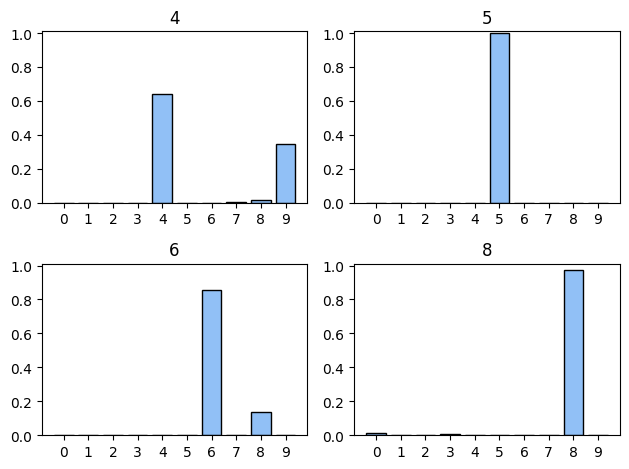

In [12]:
#proba = model.predict_proba(CoffeeShopDigits_set, verbose=0)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.bar(range(10), coffee_probs[i], color='#91C0F6', align='center', edgecolor='black')
    #plt.xlim(-0.5, 9.5)
    plt.xticks(range(10), range(10))
    plt.ylim(0, 1.01)
    plt.title('4568'[i])
plt.tight_layout()
file_helper.save_figure('coffee-shop-data-plot')
plt.show()

In [13]:
# Find the highest-scoring predictions
def get_best_classes(data):
    return np.argmax(model.predict(data), axis=1)

In [14]:
print('CoffeeShop:',get_best_classes(CoffeeShopDigits_set))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
CoffeeShop: [4 5 6 8]


In [15]:
print('Construction:',get_best_classes(ConstructionDigits_set))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Construction: [0 2 3 4 5 3 8]


In [16]:
print('Dumpster:',get_best_classes(DumpsterDigits_set))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Dumpster: [1 3 4 3]


In [17]:
print('Stencil:',get_best_classes(StencilDigits_set))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Stencil: [2 3 5]
